<a href="https://colab.research.google.com/github/FranklinCncr/TopicosEnComputacionGraficaGrupo/blob/master/5%20Convolucion%20en%20CUDA/tcg_lab_convolucion_en_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%cd "/content/drive/My Drive/topicos en grafica/lab conv cuda"

/content/drive/My Drive/topicos en grafica/lab conv cuda


In [19]:
!nvcc conv1d.cu `pkg-config --cflags --libs opencv` -o conv; ./conv

ok


In [18]:
%%writefile conv1d.cu
#include <bits/stdc++.h>
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;

__global__ void convH(float *d_imgFR, float *d_kernel, float *d_salida, int w, int h, int ch, int kernelDim){    
    
    int bidx = blockIdx.x;
    int bidy = blockIdx.y;

    int tidx = threadIdx.x;
    int tidy = threadIdx.y;

    int fil = bidx*w*ch;
    int col = bidy*ch;

    int kernelCol = ( bidy + (tidx-(kernelDim/2)) )*ch;

    if (kernelCol>=0 && kernelCol<w*ch){

      float suma = d_imgFR[ fil+kernelCol+tidy ] 
                    *
                    d_kernel[ tidx*ch + tidy ];

      atomicAdd(&d_salida[ fil+col+tidy ], suma);

    }
}

__global__ void convV(float *d_imgFR, float *d_kernel, float *d_salida, int w, int h, int ch, int kernelDim){    
    
    int bidx = blockIdx.x;
    int bidy = blockIdx.y;

    int tidx = threadIdx.x;
    int tidy = threadIdx.y;

    int fil = bidx*w*ch;
    int col = bidy*ch;

    int kernelFil = ( bidx + (tidx-(kernelDim/2)) )*w*ch;

    if (kernelFil>=0 && kernelFil<h*w*ch){

      float suma = d_imgFR[ kernelFil+col+tidy ] 
                    *
                    d_kernel[ tidx*ch + tidy ];

      atomicAdd(&d_salida[ fil+col+tidy ], suma);

    }
}



int main()
{
    Mat img = imread("coliseo.jpg"); //CV_8UC3
    int w = img.cols;
    int h = img.rows;
    int ch = img.channels();
 
    Mat imgFR;
    img.convertTo(imgFR, CV_32F, 1.0/255.0);
    int B = sizeof(float);
  
    int kernelDim = 9; //kernel de 9x9
 
    float *kernelH = new float[kernelDim*ch];
    for (int i=0; i<kernelDim; i++)
        for (int j=0; j<ch; j++)
          kernelH[i*ch + j] = 1.0/(kernelDim);
 
    float *kernelV = new float[kernelDim*ch];
    for (int i=0; i<kernelDim; i++)
        for (int j=0; j<ch; j++)
          kernelV[i*ch + j] = 1.0/(kernelDim);

    float *salida = new float[w*h*ch];
    for (int i=0; i<w*h*ch; i++)
      salida[i] = 0.0;
 
    float *salida2 = new float[w*h*ch];
    for (int i=0; i<w*h*ch; i++)
      salida2[i] = 0.0;

    float *d_imgFR;
    float *d_kernelH;
    float *d_kernelV;
    float *d_salida;
    float *d_salida2;  

    cudaMalloc((void**)&d_imgFR, w*h*ch*B);
    cudaMalloc((void**)&d_kernelH, kernelDim*ch*B);
    cudaMalloc((void**)&d_kernelV, kernelDim*ch*B);
    cudaMalloc((void**)&d_salida, w*h*ch*B);
    cudaMalloc((void**)&d_salida2, w*h*ch*B);
 
    cudaMemcpy(d_imgFR, imgFR.data, w*h*ch*B, cudaMemcpyHostToDevice);
    cudaMemcpy(d_kernelH, kernelH, kernelDim*ch*B, cudaMemcpyHostToDevice);
    cudaMemcpy(d_kernelV, kernelV, kernelDim*ch*B, cudaMemcpyHostToDevice);
    cudaMemcpy(d_salida, salida, w*h*ch*B, cudaMemcpyHostToDevice);
    cudaMemcpy(d_salida2, salida2, w*h*ch*B, cudaMemcpyHostToDevice);

    dim3 blocks( h, w ); // blockIdx.x (0...h]     , blockIdx.y(0..w] 
    dim3 threads( kernelDim, ch );  // threadIdx.x (0...3]   threadIdx.y (0..3]
 
    convH<<<blocks,threads>>>(d_imgFR, d_kernelH, d_salida, w, h, ch, kernelDim);
    cudaDeviceSynchronize();
    convV<<<blocks,threads>>>(d_salida, d_kernelV, d_salida2, w, h, ch, kernelDim);

    cudaMemcpy(salida2, d_salida2, w*h*ch*B, cudaMemcpyDeviceToHost);
 
    Mat imgSalidaFR(h, w, CV_32FC3, salida2);
    Mat imgSalida;
    imgSalidaFR.convertTo(imgSalida, CV_8U, 255.0);
    imwrite("salida1D.jpg", imgSalida);

    cudaFree(d_salida);
    cudaFree(d_imgFR);
    free(salida);
 
    cout<<"ok\n";
  
    return 0;
}

Overwriting conv1d.cu


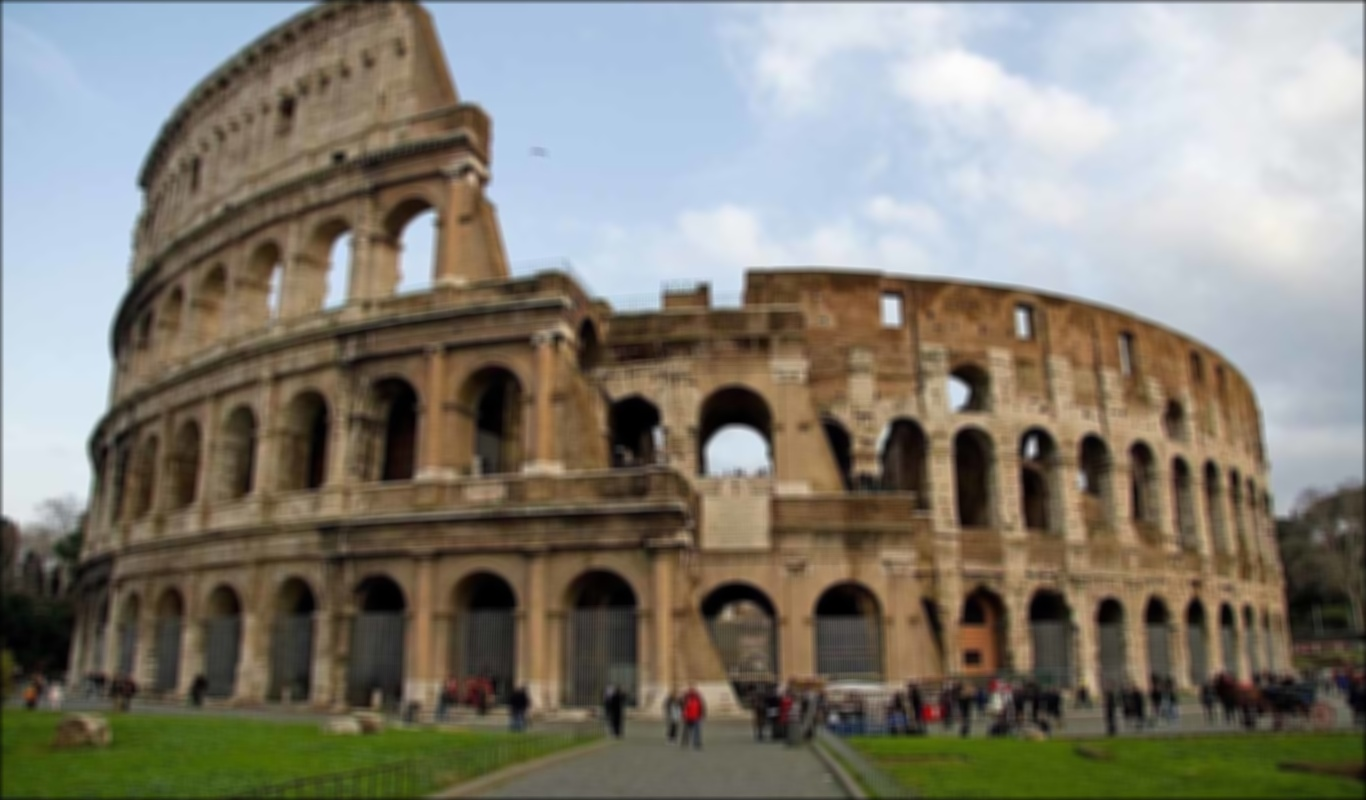

In [20]:
from IPython.display import Image, display
display(Image('salida1D.jpg'))

In [10]:
%%writefile conv2d.cu
#include <bits/stdc++.h>
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;

__global__ void conv(float *d_imgFR, float *d_kernel, float *d_salida, int w, int h, int ch, int kernelDim){    
    
    int bidx = blockIdx.x;
    int bidy = blockIdx.y;
    int bidz = blockIdx.z;

    int tidx = threadIdx.x;
    int tidy = threadIdx.y;

    int fil = bidx*w*ch;
    int col = bidy*ch;

    int kernelFil = ( bidx + (bidz-(kernelDim/2)) )*w*ch;
    int kernelCol = ( bidy + (tidx-(kernelDim/2)) )*ch;

    if (kernelFil>=0 && kernelFil<h*w*ch && kernelCol>=0 && kernelCol<w*ch){

      float suma = d_imgFR[ kernelFil+kernelCol+tidy ] 
                    *
                    d_kernel[ bidz*kernelDim*ch + tidx*ch + tidy ];

      atomicAdd(&d_salida[ fil+col+tidy ], suma);

    }
}


int main()
{
    Mat img = imread("coliseo.jpg"); //CV_8UC3
    int w = img.cols;
    int h = img.rows;
    int ch = img.channels();
 
    Mat imgFR;
    img.convertTo(imgFR, CV_32F, 1.0/255.0);
    int B = sizeof(float);
  
    int kernelDim = 9; //kernel de 9x9
 
    float *kernel = new float[kernelDim*kernelDim*ch];
    for (int i=0; i<kernelDim; i++)
      for (int j=0; j<kernelDim; j++)
        for (int k=0; k<ch; k++)
          kernel[i*kernelDim*ch + j*ch +k] = 1.0/(kernelDim*kernelDim);;

    float *salida = new float[w*h*ch];
    for (int i=0; i<w*h*ch; i++)
      salida[i] = 0.0;

    float *d_imgFR;
    float *d_kernel;
    float *d_salida;    

    cudaMalloc((void**)&d_imgFR, w*h*ch*B);
    cudaMalloc((void**)&d_kernel, kernelDim*kernelDim*ch*B);
    cudaMalloc((void**)&d_salida, w*h*ch*B);
 
    cudaMemcpy(d_imgFR, imgFR.data, w*h*ch*B, cudaMemcpyHostToDevice);
    cudaMemcpy(d_kernel, kernel, kernelDim*kernelDim*ch*B, cudaMemcpyHostToDevice);
    cudaMemcpy(d_salida, salida, w*h*ch*B, cudaMemcpyHostToDevice);

    dim3 blocks( h, w, kernelDim ); // blockIdx.x (0...h]     , blockIdx.y(0..w]      blockId.z (0...9]
    dim3 threads( kernelDim, ch );  // threadIdx.x (0...9]   threadIdx.y (0..3]
 
    conv<<<blocks,threads>>>(d_imgFR, d_kernel, d_salida, w, h, ch, kernelDim);
 
    cudaMemcpy(salida, d_salida, w*h*ch*B, cudaMemcpyDeviceToHost);
 
    Mat imgSalidaFR(h, w, CV_32FC3, salida);
    Mat imgSalida;
    imgSalidaFR.convertTo(imgSalida, CV_8U, 255.0);
    imwrite("salida2D.jpg", imgSalida);

    cudaFree(d_salida);
    cudaFree(d_imgFR);
    free(salida);
 
    cout<<"ok\n";
  
    return 0;
}

Overwriting conv2d.cu
